In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from rdkit import Chem
import dgl
import torch
from dgllife.utils import CanonicalAtomFeaturizer
from dgllife.utils import CanonicalBondFeaturizer
from dgllife.utils import mol_to_complete_graph, mol_to_bigraph
from dgllife.model import AttentiveFPPredictor
from torch import nn
 
from torch.utils.data import DataLoader

Using backend: pytorch


In [2]:
df = pd.read_csv('reddb_reaction_train.csv')
#df =pd.read_csv('reddb-smiles.csv')
train = df.head(1000)
train_smiles = train['reactantSmiles']
train_y = torch.tensor(train['reactionEnergy']).reshape(-1,1).float()

In [3]:
if torch.cuda.is_available():
    print('use GPU')
    device='cuda'
else:
    print('use CPU')
    device='cpu'

use CPU


In [4]:
mols = [Chem.MolFromSmiles(s) for s in train_smiles ]

atom_featurizer = CanonicalAtomFeaturizer(atom_data_field = 'h')
n_feats = atom_featurizer.feat_size('h')
bond_featurizer = CanonicalBondFeaturizer(bond_data_field='h')
b_feat = bond_featurizer.feat_size('h')

train_graph =[mol_to_bigraph(mol,node_featurizer=atom_featurizer, 
                           edge_featurizer=bond_featurizer) for mol in mols]


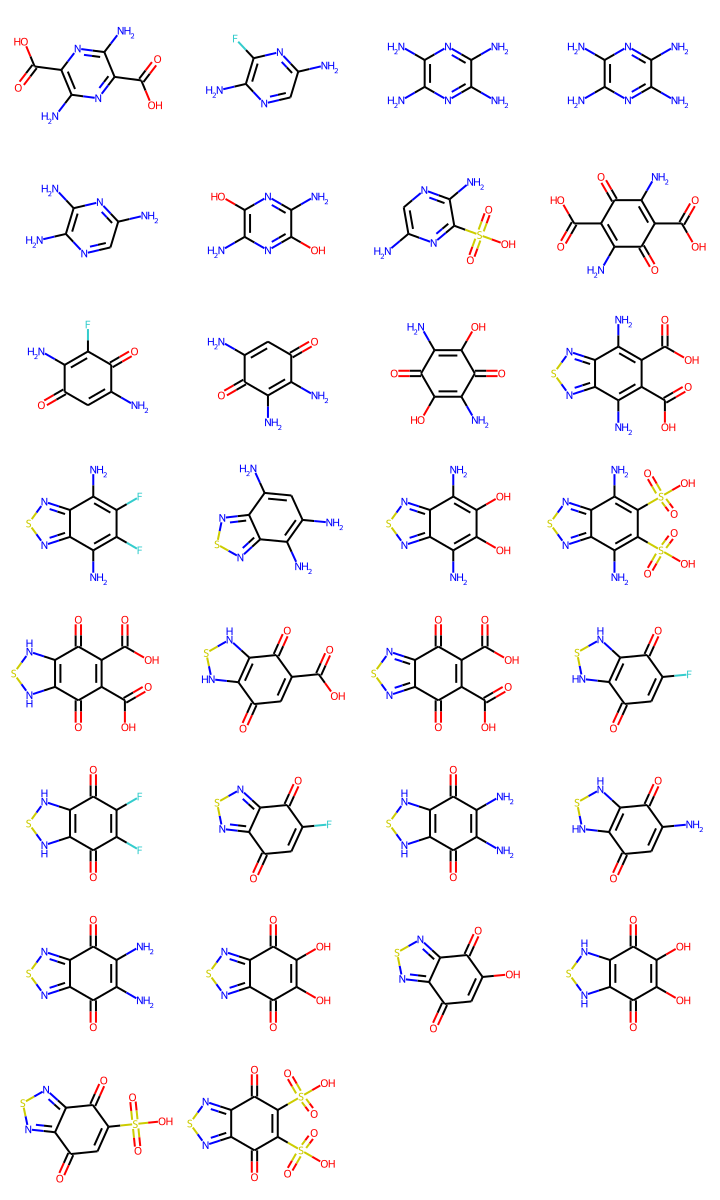

In [11]:
from rdkit import Chem
from rdkit.Chem import Draw
from IPython.display import SVG
from rdkit.Chem.Draw import IPythonConsole


# Display the molecule image in a Jupyter Notebook
Draw.MolsToGridImage(mols[:30], molsPerRow=4, subImgSize=(180, 150), useSVG=True)

In [12]:
model = AttentiveFPPredictor(node_feat_size=n_feats,
                                   edge_feat_size=b_feat,
                                   num_layers=2,
                                   num_timesteps=2,
                                   graph_feat_size=200,
                                   n_tasks=1,
                                   dropout=0.2)
#model = AttentiveFPGNN(n_feats,b_feat,2,200)
model = model.to(device)
print(model)


AttentiveFPPredictor(
  (gnn): AttentiveFPGNN(
    (init_context): GetContext(
      (project_node): Sequential(
        (0): Linear(in_features=74, out_features=200, bias=True)
        (1): LeakyReLU(negative_slope=0.01)
      )
      (project_edge1): Sequential(
        (0): Linear(in_features=86, out_features=200, bias=True)
        (1): LeakyReLU(negative_slope=0.01)
      )
      (project_edge2): Sequential(
        (0): Dropout(p=0.2, inplace=False)
        (1): Linear(in_features=400, out_features=1, bias=True)
        (2): LeakyReLU(negative_slope=0.01)
      )
      (attentive_gru): AttentiveGRU1(
        (edge_transform): Sequential(
          (0): Dropout(p=0.2, inplace=False)
          (1): Linear(in_features=200, out_features=200, bias=True)
        )
        (gru): GRUCell(200, 200)
      )
    )
    (gnn_layers): ModuleList(
      (0): GNNLayer(
        (project_edge): Sequential(
          (0): Dropout(p=0.2, inplace=False)
          (1): Linear(in_features=400, out_fea

In [13]:
def collate_molgraphs(data):
    """Batching a list of datapoints for dataloader.
    Parameters
    ----------
    data : list of 3-tuples or 4-tuples.
        Each tuple is for a single datapoint, consisting of
        a SMILES, a DGLGraph, all-task labels and optionally
        a binary mask indicating the existence of labels.
    Returns
    -------
    smiles : list
        List of smiles
    bg : BatchedDGLGraph
        Batched DGLGraphs
    labels : Tensor of dtype float32 and shape (B, T)
        Batched datapoint labels. B is len(data) and
        T is the number of total tasks.
    masks : Tensor of dtype float32 and shape (B, T)
        Batched datapoint binary mask, indicating the
        existence of labels. If binary masks are not
        provided, return a tensor with ones.
    """
    assert len(data[0]) in [3, 4], \
        'Expect the tuple to be of length 3 or 4, got {:d}'.format(len(data[0]))
    if len(data[0]) == 3:
        smiles, graphs, labels = map(list, zip(*data))
        masks = None
    else:
        smiles, graphs, labels, masks = map(list, zip(*data))
 
    bg = dgl.batch(graphs)
    bg.set_n_initializer(dgl.init.zero_initializer)
    bg.set_e_initializer(dgl.init.zero_initializer)
    labels = torch.stack(labels, dim=0)
     
    if masks is None:
        masks = torch.ones(labels.shape)
    else:
        masks = torch.stack(masks, dim=0)
    return smiles, bg, labels, masks


In [14]:
train_loader = DataLoader(dataset=list(zip(train_smiles, train_graph, train_y)), batch_size=128, collate_fn=collate_molgraphs)


In [19]:
def run_a_train_epoch(n_epochs, epoch, model, data_loader,loss_criterion, optimizer):
    model.train()
    total_loss = 0
    losses = []
     
    for batch_id, batch_data in enumerate(train_loader):
        batch_data
        smiles, bg, labels, masks = batch_data
        if torch.cuda.is_available():
            print('use GPU')
            device='cuda'
        else:
            print('use CPU')
            device='cpu'
            bg.to(device)
            labels = labels.to(device)
            masks = masks.to(device)
         
        prediction = model(bg, bg.ndata['h'], bg.edata['h'])
        loss = (loss_criterion(prediction, labels)*(masks != 0).float()).mean()
        #loss = loss_criterion(prediction, labels)
        #print(loss.shape)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
         
        losses.append(loss.data.item())
         
    #total_score = np.mean(train_meter.compute_metric('rmse'))
    total_score = np.mean(losses)
    print('epoch {:d}/{:d}, training {:.4f}'.format( epoch + 1, n_epochs,  total_score))
    return total_score


In [20]:
loss_fn = nn.MSELoss(reduction='none')
optimizer = torch.optim.Adam(model.parameters(), lr=10 ** (-2.5), weight_decay=10 ** (-5.0),)
n_epochs = 10
epochs = []
scores = []
for e in range(n_epochs):
    score = run_a_train_epoch(n_epochs, e, model, train_loader, loss_fn, optimizer)
    epochs.append(e)
    scores.append(score)
model.eval()




use CPU
use CPU
use CPU
use CPU
use CPU
use CPU
use CPU
use CPU
epoch 1/10, training 0.0178
use CPU
use CPU
use CPU
use CPU
use CPU
use CPU
use CPU
use CPU
epoch 2/10, training 0.0024
use CPU
use CPU
use CPU
use CPU
use CPU
use CPU
use CPU
use CPU
epoch 3/10, training 0.0016
use CPU
use CPU
use CPU
use CPU
use CPU
use CPU
use CPU
use CPU
epoch 4/10, training 0.0013
use CPU
use CPU
use CPU
use CPU
use CPU
use CPU
use CPU
use CPU
epoch 5/10, training 0.0029
use CPU
use CPU
use CPU
use CPU
use CPU
use CPU
use CPU
use CPU
epoch 6/10, training 0.0021
use CPU
use CPU
use CPU
use CPU
use CPU
use CPU
use CPU
use CPU
epoch 7/10, training 0.0010
use CPU
use CPU
use CPU
use CPU
use CPU
use CPU
use CPU
use CPU
epoch 8/10, training 0.0014
use CPU
use CPU
use CPU
use CPU
use CPU
use CPU
use CPU
use CPU
epoch 9/10, training 0.0023
use CPU
use CPU
use CPU
use CPU
use CPU
use CPU
use CPU
use CPU
epoch 10/10, training 0.0011


AttentiveFPPredictor(
  (gnn): AttentiveFPGNN(
    (init_context): GetContext(
      (project_node): Sequential(
        (0): Linear(in_features=74, out_features=200, bias=True)
        (1): LeakyReLU(negative_slope=0.01)
      )
      (project_edge1): Sequential(
        (0): Linear(in_features=86, out_features=200, bias=True)
        (1): LeakyReLU(negative_slope=0.01)
      )
      (project_edge2): Sequential(
        (0): Dropout(p=0.2, inplace=False)
        (1): Linear(in_features=400, out_features=1, bias=True)
        (2): LeakyReLU(negative_slope=0.01)
      )
      (attentive_gru): AttentiveGRU1(
        (edge_transform): Sequential(
          (0): Dropout(p=0.2, inplace=False)
          (1): Linear(in_features=200, out_features=200, bias=True)
        )
        (gru): GRUCell(200, 200)
      )
    )
    (gnn_layers): ModuleList(
      (0): GNNLayer(
        (project_edge): Sequential(
          (0): Dropout(p=0.2, inplace=False)
          (1): Linear(in_features=400, out_fea

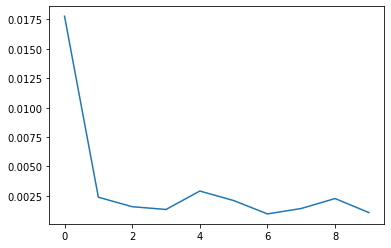

In [21]:
plt.plot(epochs, scores)

In [22]:
for batch_id, batch_data in enumerate(train_loader):
        batch_data
        smiles, bg, labels, masks = batch_data

In [23]:
bg

Graph(num_nodes=1672, num_edges=3552,
      ndata_schemes={'h': Scheme(shape=(74,), dtype=torch.float32)}
      edata_schemes={'h': Scheme(shape=(12,), dtype=torch.float32)})

In [24]:
labels

tensor([[0.0329],
        [0.0612],
        [0.0440],
        [0.0463],
        [0.0465],
        [0.0274],
        [0.0475],
        [0.0565],
        [0.0342],
        [0.0387],
        [0.0546],
        [0.0498],
        [0.0435],
        [0.0558],
        [0.0498],
        [0.0469],
        [0.0502],
        [0.0486],
        [0.0635],
        [0.0441],
        [0.0508],
        [0.0398],
        [0.0435],
        [0.0263],
        [0.0209],
        [0.0324],
        [0.0347],
        [0.0386],
        [0.0262],
        [0.0266],
        [0.0309],
        [0.0407],
        [0.0302],
        [0.0446],
        [0.0314],
        [0.0363],
        [0.0457],
        [0.0408],
        [0.0325],
        [0.0561],
        [0.0369],
        [0.0394],
        [0.0514],
        [0.0363],
        [0.0214],
        [0.0382],
        [0.0434],
        [0.0413],
        [0.0381],
        [0.0617],
        [0.0466],
        [0.0364],
        [0.0438],
        [0.0461],
        [0.0392],
        [0

In [25]:
masks

tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
      

In [26]:
smiles

['Nc1cccnc1-c2ncc(N)cc2',
 'c1c(N)nc(c(N)c1N)-c2nc(N)c(N)c(N)c2N',
 'Nc1cnc(cc1N)-c2nc(N)c(N)cc2',
 'Nc1cc(N)cnc1-c2ncc(N)cc2N',
 'n1cc(N)ccc1-c2nc(N)c(N)c(c2)N',
 'Nc1cccnc1-c2nccc(c2)N',
 'Nc1cc(N)cnc1-c2nc(N)c(N)cc2',
 'Nc1c(N)nc(cc1N)-c2nc(N)c(N)c(c2)N',
 'c1cnc(c(N)c1N)-c2ncc(N)cc2',
 'c1cnc(c(N)c1N)-c2nc(N)ccc2N',
 'Nc1cnc(c(N)c1N)-c2nc(N)cc(N)c2N',
 'Nc1cnc(cc1N)-c2nc(N)c(N)c(c2)N',
 'n1cc(N)ccc1-c2nc(N)cc(N)c2N',
 'Nc1cnc(cc1N)-c2nc(N)c(N)c(N)c2N',
 'Nc1cnc(cc1N)-c2ncc(N)c(N)c2N',
 'c1cnc(c(N)c1N)-c2nc(N)cc(N)c2N',
 'Nc1cc(N)c(N)nc1-c2nc(N)c(N)c(N)c2N',
 'c1cnc(c(N)c1N)-c2nc(N)c(N)c(c2)N',
 'Nc1cnc(c(N)c1N)-c2nc(N)c(N)c(N)c2N',
 'c1cnc(cc1N)-c2ncc(N)c(N)c2N',
 'Nc1cc(N)cnc1-c2nc(N)c(N)c(c2)N',
 'Nc1cnc(cc1N)-c2nc(N)ccc2N',
 'Nc1ccc(N)nc1-c2nc(N)c(N)c(N)c2N',
 'n1ccccc1-c2nc(N)cc(c2)N',
 'n1ccccc1-c2nc(N)ccc2',
 'n1ccccc1-c2nc(N)cc(N)c2N',
 'Nc1cccnc1-c2ncc(N)c(c2)N',
 'c1cnc(cc1N)-c2ncc(N)cc2',
 'n1c(N)cccc1-c2nc(N)ccc2',
 'n1ccccc1-c2nc(N)ccc2N',
 'n1c(N)cccc1-c2nc(N)cc(c2)N',

In [27]:
df_test = pd.read_csv('reddb_reaction_test.csv')
#df =pd.read_csv('reddb-smiles.csv')
test = df_test.head(500)
test_smiles = test['reactantSmiles']
test_y = torch.tensor(test['reactionEnergy']).reshape(-1,1).float()


test_mols = [Chem.MolFromSmiles(s) for s in test_smiles ]

test_graph =[mol_to_bigraph(mol,
                           node_featurizer=atom_featurizer, 
                           edge_featurizer=bond_featurizer) for mol in test_mols]

test_loader = DataLoader(dataset=list(zip(test_smiles, test_graph, test_y)), batch_size=128, collate_fn=collate_molgraphs,drop_last=True)



In [28]:
all_pred = []
for batch_id, batch_data in enumerate(test_loader):
    batch_data
    smiles, bg, labels, masks = batch_data
    if torch.cuda.is_available():
        print('use GPU')
        device='cuda'
    else:
        print('use CPU')
        device='cpu'
        bg.to(device)
        labels = labels.to(device)
        masks = masks.to(device)
         
    pred = model(bg, bg.ndata['h'], bg.edata['h'])
    all_pred.append(pred.data.cpu().numpy())

use CPU
use CPU
use CPU


In [29]:
res=model(bg,bg.ndata['h'], bg.edata['h']).detach().numpy()
res = np.vstack(all_pred)
print(res.shape)

(384, 1)


Text(0, 0.5, 'exp')

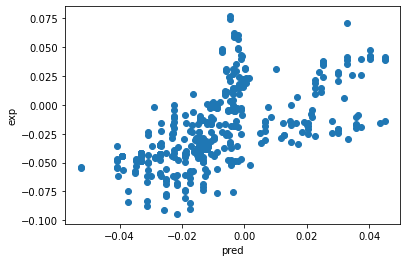

In [31]:
plt.clf()
plt.scatter(res,test_y[:384])
plt.xlabel('pred')
plt.ylabel('exp')

In [33]:
import copy
from rdkit.Chem import rdDepictor
from rdkit.Chem.Draw import rdMolDraw2D
from IPython.display import SVG
from IPython.display import display
import matplotlib
import matplotlib.cm as cm

from torch.utils.data import Dataset

In [35]:
def drawmol(idx, dataset, timestep):
    smiles, graph, _ = dataset[idx]
    print(smiles)
    bg = dgl.batch([graph])
    atom_feats, bond_feats = bg.ndata['h'], bg.edata['h']
    if torch.cuda.is_available():
        print('use GPU')
        device='cuda'
    else:
        print('use CPU')
        device='cpu'
        bg.to(device)
        atom_feats = atom_feats.to(device)
        bond_feats = bond_feats.to(device)
    
    _, atom_weights = model(bg, atom_feats, bond_feats, get_node_weight=True)
    assert timestep < len(atom_weights), 'Unexpected id for the readout round'
    atom_weights = atom_weights[timestep]
    min_value = torch.min(atom_weights)
    max_value = torch.max(atom_weights)
    atom_weights = (atom_weights - min_value) / (max_value - min_value)
    
    norm = matplotlib.colors.Normalize(vmin=0, vmax=1.28)
    cmap = cm.get_cmap('bwr')
    plt_colors = cm.ScalarMappable(norm=norm, cmap=cmap)
    atom_colors = {i: plt_colors.to_rgba(atom_weights[i].data.item()) for i in range(bg.number_of_nodes())}

    mol = Chem.MolFromSmiles(smiles)
    rdDepictor.Compute2DCoords(mol)
    drawer = rdMolDraw2D.MolDraw2DSVG(280, 280)
    drawer.SetFontSize(1)
    op = drawer.drawOptions()
    
    mol = rdMolDraw2D.PrepareMolForDrawing(mol)
    drawer.DrawMolecule(mol, highlightAtoms=range(bg.number_of_nodes()),
                             highlightBonds=[],
                             highlightAtomColors=atom_colors)
    drawer.FinishDrawing()
    svg = drawer.GetDrawingText()
    svg = svg.replace('svg:', '')
    if torch.cuda.is_available():
        atom_weights = atom_weights.to('cpu')
    return (Chem.MolFromSmiles(smiles), atom_weights.data.numpy(), svg)

In [36]:

target = test_loader.dataset

In [37]:
res = drawmol(0, target, 0)


Nc1c(C(=O)O)nc(cn1)N
use CPU


Nc1c(C(=O)O)nc(cn1)N
use CPU


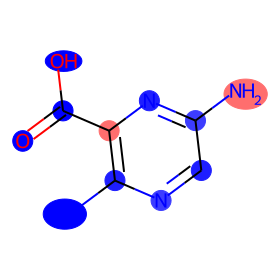

Nc1c(F)nc(c(n1)F)N
use CPU


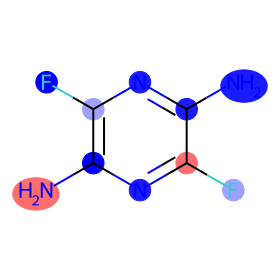

Nc1c(N)nc(cn1)N
use CPU


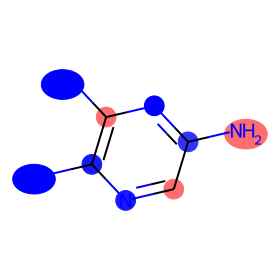

Nc1cnc(N)c(n1)O
use CPU


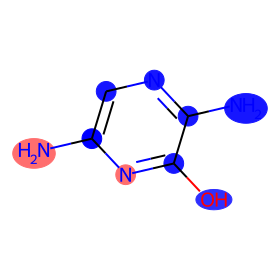

Nc1c(S(=O)(=O)O)nc(N)c(n1)S(=O)(=O)O
use CPU


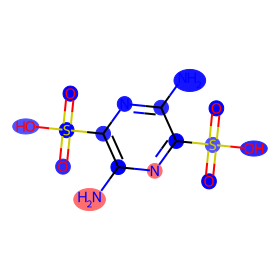

O=C1C(N)=CC(=O)C(N)=C1C(=O)O
use CPU


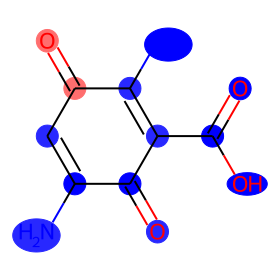

O=C1C(N)=C(F)C(=O)C(=C1F)N
use CPU


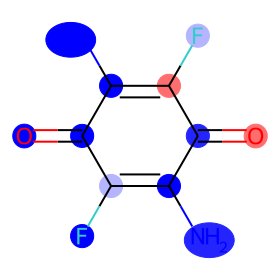

O=C1C(N)=C(N)C(=O)C(N)=C1N
use CPU


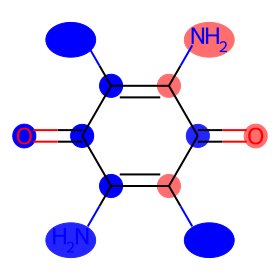

O=C1C(N)=C(O)C(=O)C(=C1)N
use CPU


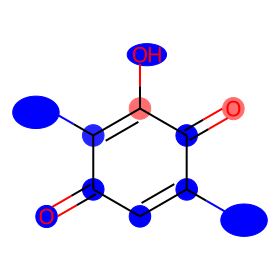

O=C1C(N)=C(S(=O)(=O)O)C(=O)C(N)=C1S(=O)(=O)O
use CPU


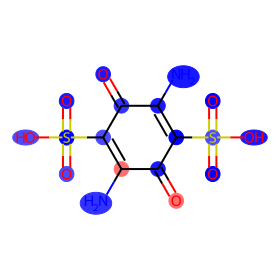

In [38]:
for i in range(10):
    mol, aw, svg = drawmol(i, target, 0)
    display(SVG(svg))

you can find reference code :
https://gist.github.com/iwatobipen/72a2d9dd616322f1f20469a152f2bb58 
https://nbviewer.jupyter.org/gist/iwatobipen/017fae146c1d67a2cfee455c0a427330